In [34]:
%matplotlib notebook
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
import numpy as np
import matplotlib as mpl
from pylab import rcParams

mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.serif']        = 'Times New Roman' #picks the font
mpl.rcParams['axes.labelsize']    = 16

import statsmodels.api as sm

In [24]:
# Import Covid-19 data into a pandas table
parser = lambda x: pd.to_datetime(x, utc = True, format = '%m/%d/%Y')
df = pd.read_csv('Bing-COVID19-Data.csv', delimiter=',', parse_dates = True, index_col = "Updated",
                date_parser = parser)

In [48]:
# Create indices
id_global = df["Country_Region"]=="Worldwide"
id_us = ~pd.notna(df["AdminRegion1"]) & (df["Country_Region"]=="United States")
id_march =  df.index >= pd.to_datetime('03/01/2020', utc = True)
id_train = df.index <= pd.to_datetime('05/01/2020', utc = True)

In [323]:
# Train ARMA model w/all the global data date until May
print('ARMA model 5: global, all confirmed cases until May')
print('*'*50)
arma_model_1 = sm.tsa.ARMA(df["Confirmed"][id_global & id_train], (3,0)).fit(disp = False)
print(arma_model_1.summary())

ARMA model 5: global, all confirmed cases until May
**************************************************
                              ARMA Model Results                              
Dep. Variable:              Confirmed   No. Observations:                  102
Model:                     ARMA(3, 0)   Log Likelihood               -1108.691
Method:                       css-mle   S.D. of innovations          19805.491
Date:                Tue, 19 May 2020   AIC                           2227.381
Time:                        16:18:51   BIC                           2240.506
Sample:                    01-21-2020   HQIC                          2232.696
                         - 05-01-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.537e+05      0.593   1.27e+06      0.000    7.54e+05    7.54e+05
ar.L1.Confirm

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [324]:
# Train ARMA model w/all US data date until May for US data
print('ARMA model 2: US, all confirmed cases until May')
print('*'*50)
arma_model_2 = sm.tsa.ARMA(df["Confirmed"][id_us & id_train], (7,0)).fit() #(1,0) (7,0)
print(arma_model_2.summary())
#sm.tsa.ARMA()

ARMA model 2: US, all confirmed cases until May
**************************************************


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              Confirmed   No. Observations:                  101
Model:                     ARMA(7, 0)   Log Likelihood                     nan
Method:                       css-mle   S.D. of innovations           3224.633
Date:                Tue, 19 May 2020   AIC                                nan
Time:                        16:19:07   BIC                                nan
Sample:                             0   HQIC                               nan
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.134e+05      0.310   6.89e+05      0.000    2.13e+05    2.13e+05
ar.L1.Confirmed     2.3836   2.75e-05   8.67e+04      0.000       2.384       2.384
ar.L2.Confirmed    -2.0129   2.4

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [326]:
# Make a prediction w/ARMA model 5 for the May data
date_predict_5 = pd.date_range(start = '2020-05-01', end = '2020-05-25', tz = 'utc')
y_predict_1, y_err_1, conf_1 = arma_model_1.forecast(25)

# prediction for ARMA model k6
y_predict_2, y_err_2, conf_2 = arma_model_2.forecast(25)

<IPython.core.display.Javascript object>


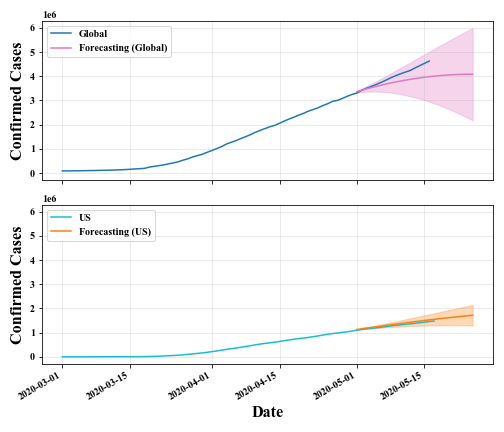

In [393]:
fig, ax = plt.subplots(2,1, figsize = (7,6), sharey = True, sharex = True)
ax[0].plot(df["Confirmed"][id_global & id_march], label = 'Global')
ax[1].plot(df["Confirmed"][id_us & id_march], label = 'US', color = 'tab:cyan')


# plot prediciton w/confidence intervals
ax[0].plot(date_predict_5, y_predict_1, color = 'tab:pink', label = 'Forecasting (Global)')
ax[0].fill_between(date_predict_5, conf_1[:,0], conf_1[:,1], alpha = 0.3,
                 color = 'tab:pink')
# for US model
ax[1].plot(date_predict_5, y_predict_2, color = 'tab:orange', label = 'Forecasting (US)')
ax[1].fill_between(date_predict_5, conf_2[:,0], conf_2[:,1], alpha = 0.3,
                  color = 'tab:orange')

ax[0].set_ylabel('Confirmed Cases', size = 16)
ax[1].set_ylabel('Confirmed Cases', size = 16)
ax[1].set_xlabel('Date', size = 16)
ax[0].legend(loc = 'upper left')
ax[1].legend(loc = 'upper left')

ax[0].grid(lw = 0.5, alpha = 0.5)
ax[1].grid(lw = 0.5, alpha = 0.5)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.ylabel()
fig.autofmt_xdate()
fig.tight_layout()
#fig.savefig('confirmed_cases_plot', dpi=400, bbox_inches = 'tight')

In [322]:
"""
Make a deaths from CoVID-19 model, w/the global data 

The US data on deaths from CoVID-19 is too small to create accurate models.
"""
arma_model_1d = sm.tsa.ARMA(df["Deaths"][id_global & id_train], (2,0)).fit(disp = False)
#print(arma_model_1d.summary())

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [315]:
# Make a prediction w/ARMA model 1d for the May data
date_predict = pd.date_range(start = '2020-05-01', end = '2020-05-25', tz = 'utc')
y_predict_1d, y_err_1d, conf_1d = arma_model_1d.forecast(25)

<IPython.core.display.Javascript object>


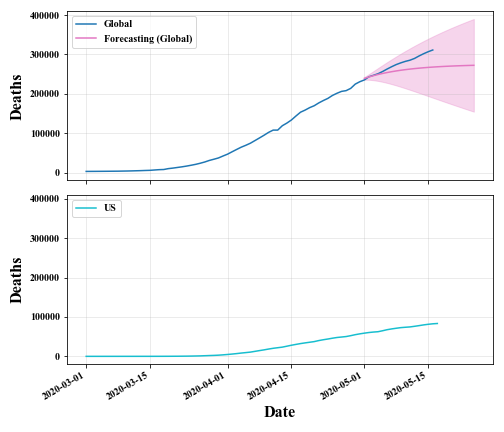

In [353]:
fig, ax = plt.subplots(2,1, figsize = (7,6), sharey = True, sharex = True)
ax[0].plot(df["Deaths"][id_global & id_march], label = 'Global')
ax[1].plot(df["Deaths"][id_us & id_march], label = 'US', color = 'tab:cyan')

# plot prediciton w/confidence intervals
ax[0].plot(date_predict, y_predict_1d, color = 'tab:pink', label = 'Forecasting (Global)')
ax[0].fill_between(date_predict, conf_1d[:,0], conf_1d[:,1], alpha = 0.3,
                  color = 'tab:pink')

ax[1].set_xlabel('Date', size = 16)
ax[0].set_ylabel('Deaths', size = 16)
ax[1].set_ylabel('Deaths', size = 16)
ax[0].grid(lw = 0.5, alpha = 0.5)
ax[1].grid(lw = 0.5, alpha = 0.5)
ax[0].legend(loc = 'upper left')
ax[1].legend(loc = 'upper left')
fig.autofmt_xdate()
fig.tight_layout()
#fig.savefig('deaths_plot', dpi=400, bbox_inches = 'tight')